In [1]:
!pip install pyspellchecker

import numpy as np
import pandas as pd
import os
import string

from spellchecker import SpellChecker

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from keras import Model
from keras.models import load_model
from keras.layers import TextVectorization, Input, Dropout, Dense, Activation, BatchNormalization
from keras.initializers import RandomNormal
from keras.utils import plot_model
from keras.regularizers import L2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.8 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-labelled-sentences/amazon_cells_labelled.txt
/kaggle/input/sentiment-labelled-sentences/imdb_labelled.txt
/kaggle/input/sentiment-labelled-sentences/readme.txt
/kaggle/input/sentiment-labelled-sentences/yelp_labelled.txt


In [3]:
amazon = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/amazon_cells_labelled.txt', 
                     sep='\t',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
imdb = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/imdb_labelled.txt', 
                     sep='\t|\s{3}',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
yelp = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/yelp_labelled.txt', 
                     sep='\t',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
print(f"amazon = {amazon.shape}, imdb = {imdb.shape}, yelp = {yelp.shape}")

amazon = (1000, 2), imdb = (1000, 2), yelp = (1000, 2)


/tmp/ipykernel_23/1264589513.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imdb = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/imdb_labelled.txt',


In [4]:
print('negatywna emocja amazon:',amazon[amazon['sentiment'] == 0]['sentance'].count())
print('pozytywna emocja amazon:',amazon[amazon['sentiment'] == 1]['sentance'].count())
print('negatywna emocja imdb:',imdb[imdb['sentiment'] == 0]['sentance'].count())
print('pozytywna emocja imdb:',imdb[imdb['sentiment'] == 1]['sentance'].count())
print('negatywna emocja yelp:',yelp[yelp['sentiment'] == 0]['sentance'].count())
print('pozytywna emocja yelp:',yelp[yelp['sentiment'] == 1]['sentance'].count())

negatywna emocja amazon: 500
pozytywna emocja amazon: 500
negatywna emocja imdb: 500
pozytywna emocja imdb: 500
negatywna emocja yelp: 500
pozytywna emocja yelp: 500


In [5]:
data = pd.DataFrame(data=np.concatenate([amazon,imdb,yelp], axis=0), columns=['sentance', 'sentiment'])
data.shape

(3000, 2)

In [6]:
data

,sentance,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2995,I think food should have flavor and texture an...,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go b...,0
2998,"The whole experience was underwhelming, and I ...",0


<Axes: ylabel='sentiment'>

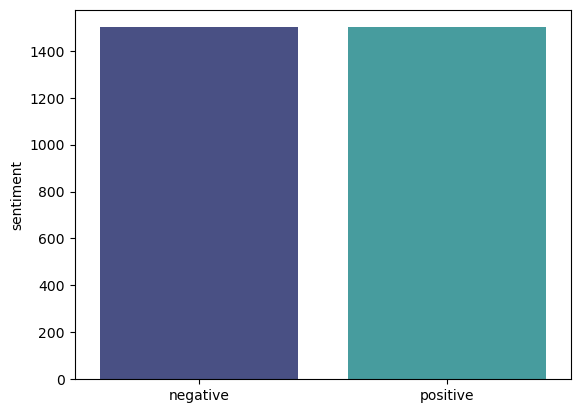

In [7]:
x = data['sentiment'].value_counts()
sns.barplot(x=['negative', 'positive'], y=x, palette='mako')

In [8]:
sc = SpellChecker()
stemmer = SnowballStemmer(language='english')

def remove_punc(sentance):
    return sentance.translate(str.maketrans('','',string.punctuation))


def correct(sentance):
    misspelled = sc.unknown(str(sentance).split())
    correct = [sc.correction(w) if w in misspelled else w for w in sentance.split()]
    return " ".join(filter(lambda c : c is not None, correct))


def remove_stop(sentance):
    correct = [w for w in sentance.split() if w not in stopwords.words('english')]
    return " ".join(correct)


def stemming(sentance):
    correct = [stemmer.stem(w) for w in sentance.split()]
    return " ".join(correct)


def remove_numbers(sentance):
    return " ".join([s for s in sentance.split() if not s.isdigit()])

In [9]:
print('The letters in Maryland, USA were big, but now they are not'.lower())

the letters in maryland, usa were big, but now they are not


In [10]:
print(remove_punc('What? Where did all the punctuation go????'))

What Where did all the punctuation go


In [11]:
print(correct('its spellinf timr'))

its spelling time


In [12]:
print(remove_stop('There are no longer stop words, so why even bother.'))

There longer stop words, even bother.


In [13]:
print(stemming('It is finally time for some good old stemming shenanigans'))

it is final time for some good old stem shenanigan


In [14]:
def prepare_data(sentance, vectorizer=None):
    sentance = sentance.lower()
    sentance = remove_punc(sentance)
    sentance = correct(sentance)
    sentance = remove_stop(sentance)
    sentance = stemming(sentance)
    if vectorizer is None:
        return sentance
    else: 
        return np.asarray(vectorizer(sentance).numpy(), dtype='float32').reshape(1,-1)

In [15]:
def count_unique(sentances):
    unique = set()
    [unique.update(s.split()) for s in sentances]
    return len(unique)

In [16]:
x = data['sentance']
y = data['sentiment']
x

0       So there is no way for me to plug it in here i...
1                             Good case, Excellent value.
2                                  Great for the jawbone.
3       Tied to charger for conversations lasting more...
4                                       The mic is great.
                              ...                        
2995    I think food should have flavor and texture an...
2996                             Appetite instantly gone.
2997    Overall I was not impressed and would not go b...
2998    The whole experience was underwhelming, and I ...
2999    Then, as if I hadn't wasted enough of my life ...
Name: sentance, Length: 3000, dtype: object

In [17]:
words = {}

words['Original text'] = count_unique(x)

x = x.map(lambda x : x.lower())
words['No capital'] = count_unique(x)

x = x.map(lambda x : remove_punc(x))
words['No punctuation'] = count_unique(x)

x = x.map(lambda x : correct(x))
words['Corrected'] = count_unique(x)

x = x.map(lambda x : remove_stop(x))
words['No stop words'] = count_unique(x)

x = x.map(lambda x : stemming(x))
words['Stemmed'] = count_unique(x)

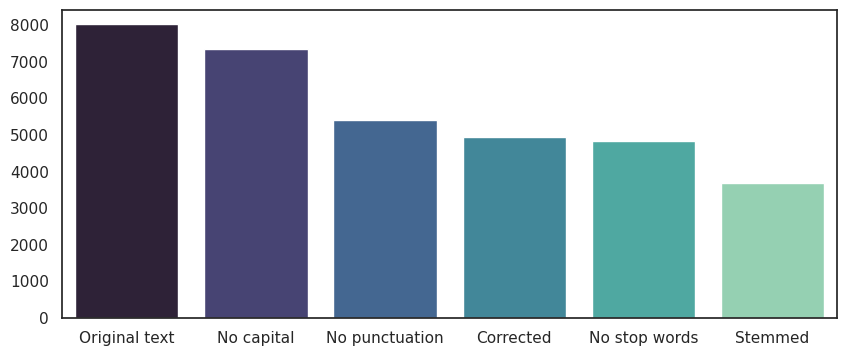

In [18]:
sns.set(rc={"figure.figsize":(10, 4)})
sns.set_style("white")
sns.barplot(x=list(words.keys()), y=list(words.values()), palette='mako')
plt.show()

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

In [20]:
data_to_adapt = tf.constant(x_train)

n = 5

vectorizer = TextVectorization(output_mode='tf-idf', ngrams=n)
vectorizer.adapt(data_to_adapt)

In [21]:
x[0]

'way plug us unless go convert'

In [22]:
vectorizer(x[0]).numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [23]:
x_train = x_train.map(lambda x : vectorizer(x).numpy())
x_test = x_test.map(lambda x : vectorizer(x).numpy())

x_train = np.asarray([x.astype('float32') for x in x_train])
x_test = np.asarray([x.astype('float32') for x in x_test])

y_train = np.asarray(y_train, dtype='float32')
y_test = np.asarray(y_test, dtype='float32')

In [24]:
def make_model(input_size):
    latent = [1024, 512, 256, 128, 64, 32]

    inputs = Input(shape=(input_size, ))
    layer = inputs

    for l in latent:
        layer = Dense(l, 
                      activation='relu',
                      kernel_initializer=RandomNormal(stddev=0.01),
                      kernel_regularizer=L2(1e-5), 
                      bias_regularizer=L2(1e-5))(layer)
    
        layer = BatchNormalization()(layer)
        layer = Dropout(0.4)(layer)

    outputs = Dense(1, activation='sigmoid')(layer)

    model = Model(inputs, outputs)
    return model

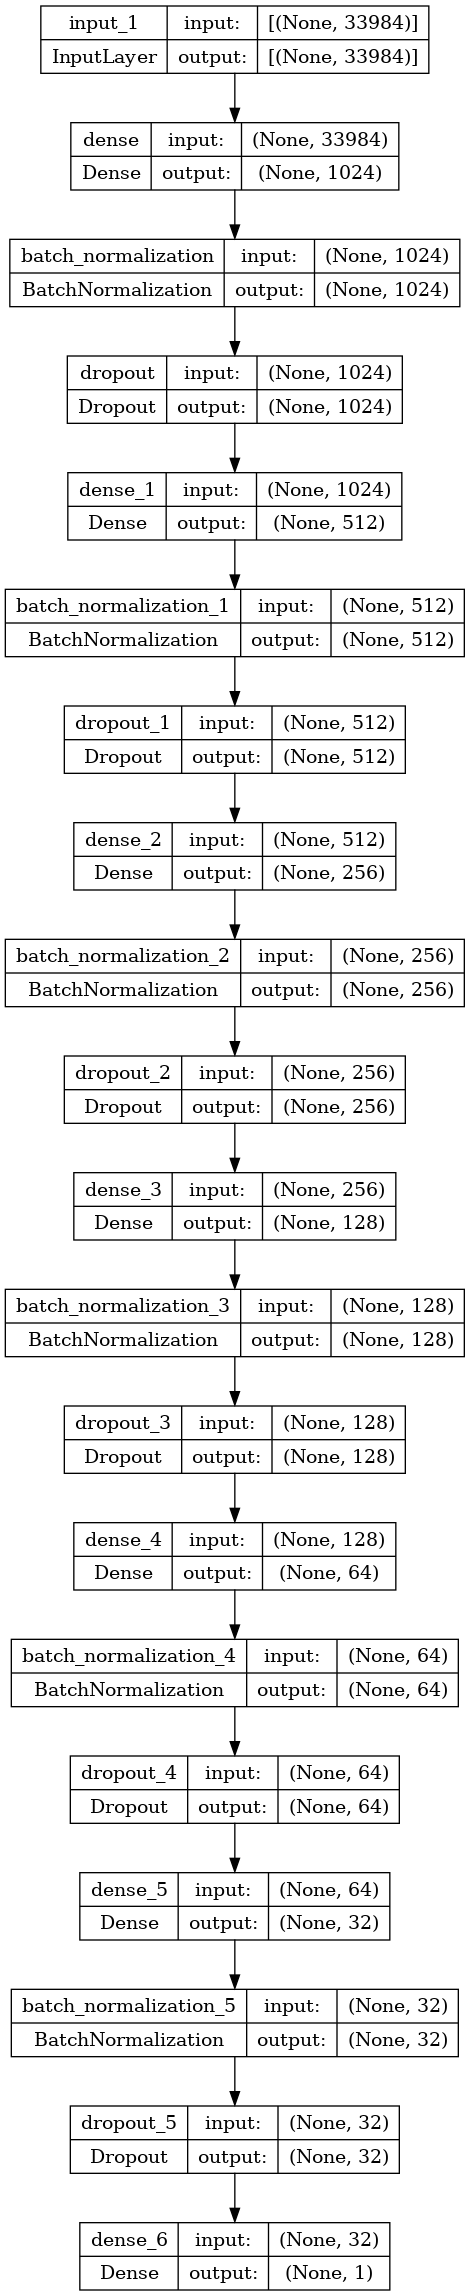

In [25]:
model = make_model(vectorizer.vocabulary_size())
plot_model(model, show_shapes=True)

In [26]:
callback = EarlyStopping(monitor='val_accuracy', patience=10)

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, 
                    validation_split=0.2, 
                    epochs=50, batch_size=128, 
                    callbacks=[callback])

Epoch 1/50
14/14 [==============================] - 6s 68ms/step - loss: 0.9498 - accuracy: 0.5220 - val_loss: 1.1708 - val_accuracy: 0.5452
Epoch 2/50
14/14 [==============================] - 0s 31ms/step - loss: 0.9762 - accuracy: 0.5423 - val_loss: 1.1062 - val_accuracy: 0.5690
Epoch 3/50
14/14 [==============================] - 0s 32ms/step - loss: 1.0701 - accuracy: 0.5804 - val_loss: 1.1262 - val_accuracy: 0.6071
Epoch 4/50
14/14 [==============================] - 0s 32ms/step - loss: 1.0257 - accuracy: 0.7095 - val_loss: 1.0688 - val_accuracy: 0.6929
Epoch 5/50
14/14 [==============================] - 0s 31ms/step - loss: 0.8733 - accuracy: 0.8143 - val_loss: 1.1214 - val_accuracy: 0.6405
Epoch 6/50
14/14 [==============================] - 0s 32ms/step - loss: 0.6887 - accuracy: 0.9077 - val_loss: 1.1132 - val_accuracy: 0.7643
Epoch 7/50
14/14 [==============================] - 0s 31ms/step - loss: 0.6246 - accuracy: 0.9393 - val_loss: 1.7848 - val_accuracy: 0.7048
Epoch 8/50
14

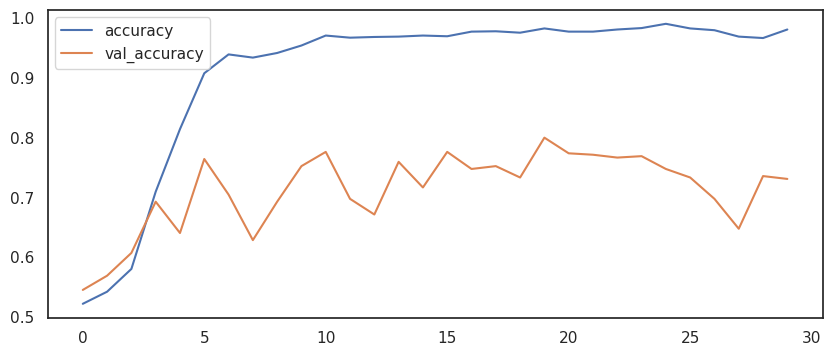

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [28]:
model.evaluate(x_test, y_test)

29/29 [==============================] - 0s 5ms/step - loss: 1.4421 - accuracy: 0.7533


[1.4421371221542358, 0.753333330154419]

In [29]:
dict = {0 : 'negative', 1 : 'positive'}

def predict_sentiment(sentance, vectorizer, model, feature_selection=None):
    if feature_selection is None:
        data = prepare_data(sentance, vectorizer)
    else: 
        data = feature_selection.transform(prepare_data(sentance, vectorizer))
    prediction = np.round(model.predict(data))
    return dict.get(prediction.item())

In [30]:
predict_sentiment('Good', vectorizer, model)

1/1 [==============================] - 0s 198ms/step


'negative'

In [31]:
model.save('/kaggle/working/sentiment_model.h5')

In [32]:
def show_scores(arr_x, arr_y, model, conv):
    if conv:
        y_tmp = []
        for k in arr_x:
            tmp = np.array([k])
            y_tmp.append(np.round(model.predict(tmp, verbose = 0)))

        y_pred = []
        y_true = []
        for k in y_tmp:
            y_pred.append(int(k[0][0]))

        for k in arr_y:
            y_true.append(k)

        confusion = confusion_matrix(y_true, y_pred)
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(confusion.shape[0]):
            for j in range(confusion.shape[1]):
                ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')

        plt.ylabel('Predicted', fontsize=18)
        plt.title('Expected', fontsize=18)
        plt.show()
        print(classification_report(y_true, y_pred))
    else:
        y_pred = model.predict(arr_x)
        confusion = confusion_matrix(arr_y, y_pred)
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(confusion.shape[0]):
            for j in range(confusion.shape[1]):
                ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')

        plt.ylabel('Predicted', fontsize=18)
        plt.title('Expected', fontsize=18)
        plt.show()
        print(classification_report(arr_y, y_pred))

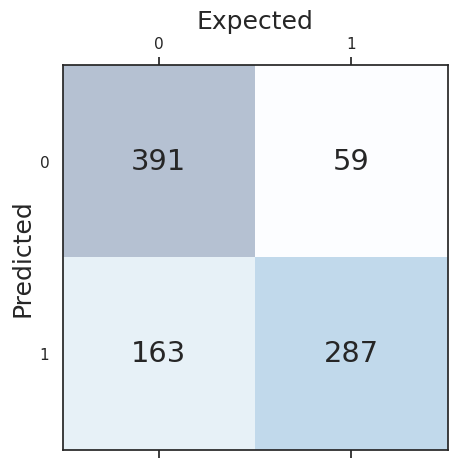

              precision    recall  f1-score   support

         0.0       0.71      0.87      0.78       450
         1.0       0.83      0.64      0.72       450

    accuracy                           0.75       900
   macro avg       0.77      0.75      0.75       900
weighted avg       0.77      0.75      0.75       900



In [33]:
show_scores(x_test, y_test, model, True)

In [34]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc.score(x_test, y_test)

0.7622222222222222

In [35]:
predict_sentiment('Wow, such a nice product!', vectorizer, rfc)

'positive'

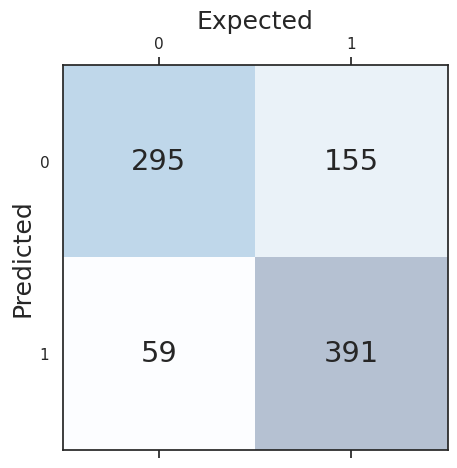

              precision    recall  f1-score   support

         0.0       0.83      0.66      0.73       450
         1.0       0.72      0.87      0.79       450

    accuracy                           0.76       900
   macro avg       0.77      0.76      0.76       900
weighted avg       0.77      0.76      0.76       900



In [36]:
show_scores(x_test, y_test, rfc, False)

In [37]:
sp = SelectPercentile(chi2, percentile=10)
x_train = sp.fit_transform(x_train, y_train)

x_test = sp.transform(x_test)

rfc2 = RandomForestClassifier()
rfc2.fit(x_train, y_train)
rfc2.score(x_test, y_test)

0.7888888888888889

In [38]:
predict_sentiment('Good', vectorizer, rfc2, sp)

'positive'

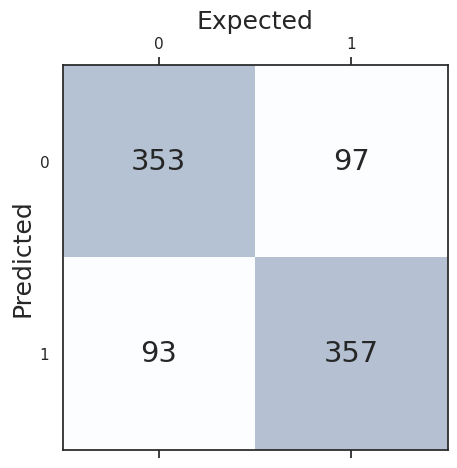

              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79       450
         1.0       0.79      0.79      0.79       450

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.79       900
weighted avg       0.79      0.79      0.79       900



In [39]:
show_scores(x_test, y_test, rfc2, False)

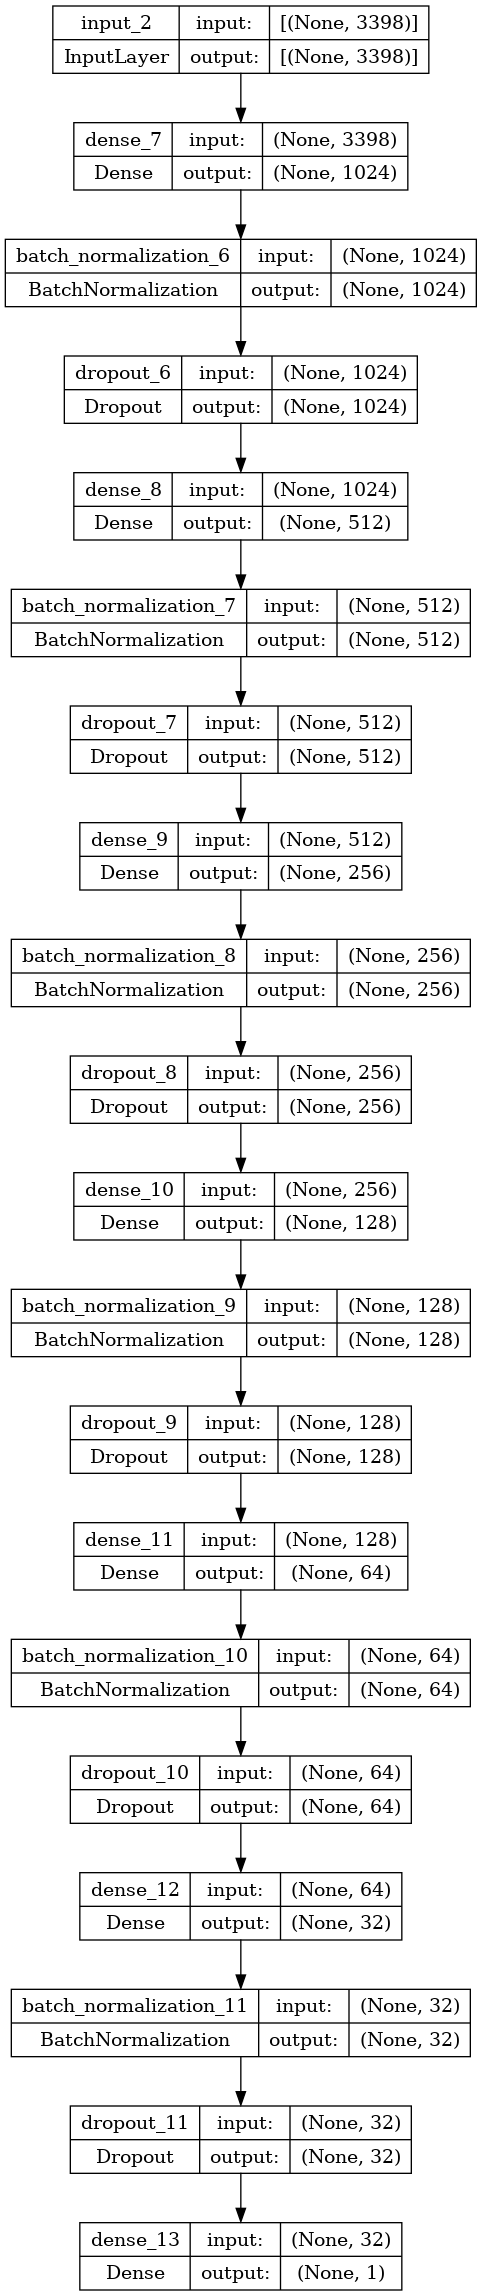

In [40]:
model2 = make_model(x_train.shape[1])
plot_model(model2, show_shapes=True)

In [41]:
model2.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x=x_train, y=y_train, 
                    validation_split=0.2, 
                    epochs=50, batch_size=128, 
                    callbacks=[callback])

Epoch 1/50
14/14 [==============================] - 2s 39ms/step - loss: 0.8206 - accuracy: 0.5554 - val_loss: 0.7252 - val_accuracy: 0.4762
Epoch 2/50
14/14 [==============================] - 0s 13ms/step - loss: 0.6088 - accuracy: 0.7113 - val_loss: 0.6408 - val_accuracy: 0.7976
Epoch 3/50
14/14 [==============================] - 0s 13ms/step - loss: 0.3932 - accuracy: 0.8827 - val_loss: 0.4941 - val_accuracy: 0.8095
Epoch 4/50
14/14 [==============================] - 0s 13ms/step - loss: 0.2789 - accuracy: 0.9292 - val_loss: 0.4959 - val_accuracy: 0.8381
Epoch 5/50
14/14 [==============================] - 0s 13ms/step - loss: 0.2320 - accuracy: 0.9429 - val_loss: 0.5609 - val_accuracy: 0.8452
Epoch 6/50
14/14 [==============================] - 0s 13ms/step - loss: 0.2359 - accuracy: 0.9476 - val_loss: 0.6071 - val_accuracy: 0.8690
Epoch 7/50
14/14 [==============================] - 0s 13ms/step - loss: 0.2502 - accuracy: 0.9393 - val_loss: 0.7414 - val_accuracy: 0.8333
Epoch 8/50
14

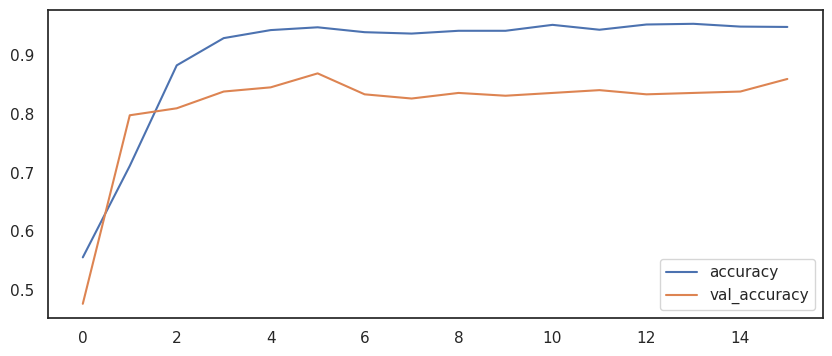

In [42]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [43]:
model2.evaluate(x_test, y_test)

29/29 [==============================] - 0s 4ms/step - loss: 1.2357 - accuracy: 0.7711


[1.235668420791626, 0.7711111307144165]

In [44]:
model2.save('/kaggle/working/sentiment_model_with_fetures.h5')

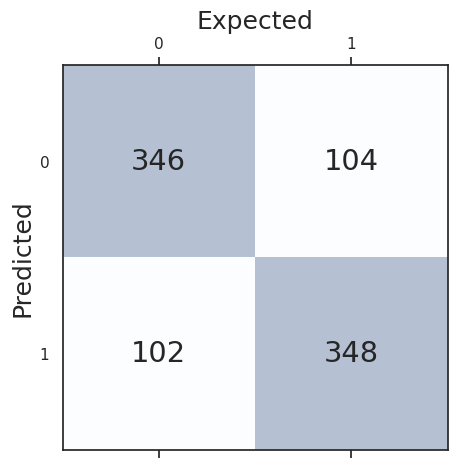

              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77       450
         1.0       0.77      0.77      0.77       450

    accuracy                           0.77       900
   macro avg       0.77      0.77      0.77       900
weighted avg       0.77      0.77      0.77       900



In [45]:
show_scores(x_test, y_test, model2, True)